# 1. Data Preperation

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [2]:
#Load pre-existing park data
parks_lst_gdf = gpd.read_file('Data/Riyadh_parks_with_LST.geojson')
print("Loaded parks_gdf with columns:", parks_lst_gdf.columns) 

Loaded parks_gdf with columns: Index(['osm_id', 'OBJECTID', 'FEATURE_ANAME', 'MUNICIPALITY', 'DISTRICT',
       'WALKING_TRACK', 'GREEN_AREAS', 'LAYERID', 'LAYERANAME', 'Validation',
       'Park_id', 'area_m2', 'perimeter_m', 'LSI', 'ndvi_mean',
       'ndvi_pixel_count', 'pisi_mean', 'pisi_pixel_count', 'lst_buffer_30m',
       'lst_buffer_60m', 'lst_buffer_90m', 'lst_buffer_120m',
       'lst_buffer_150m', 'lst_buffer_180m', 'lst_buffer_210m',
       'lst_buffer_240m', 'lst_buffer_270m', 'lst_buffer_300m', 'lst_park',
       'park_pixel_count', 'lst_data', 'cubic_coeffs', 'r_squared', 'PCD',
       'PCI', 'PCA', 'PCE', 'geometry'],
      dtype='object')


In [3]:
# Select relevant columns for the analysis
data_df = parks_lst_gdf[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI', 'PCI', 'PCA', 'PCE']].copy() ## Create a copy of the specified columns to avoid SettingWithCopyWarning

In [4]:
# Check if any row has na

num_rows_with_na = data_df.isna().any(axis=1).sum()
print(f'Number of rows with NaN values: {num_rows_with_na}')


Number of rows with NaN values: 0


Here, the independent variables were normalized using StandardScaler which performs same transformation as the z score method used in litratire [Sun et al., 2024](https://www.sciencedirect.com/science/article/abs/pii/S1618866724000621)

In [5]:
# scaler = StandardScaler()

# data_df[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']] = scaler.fit_transform(data_df[['ndvi_mean', 'pisi_mean', 'area_m2', 'LSI']])

In [6]:
# data_df_cooling = data_df['PCI'].apply(lambda x: 'Cooling' if x < 0 else 'Heating')

In [6]:
# Create a new DataFrame to avoid modifying the original
filtered_parks_gdf = parks_lst_gdf.copy()
# Extract centroids for distance calculation
centroids = filtered_parks_gdf.copy()
centroids['geometry'] = centroids.geometry.centroid

# Initialize a set to track parks to remove (both from each close pair)
parks_to_remove = set()

# Calculate pairwise distances and identify close pairs (<300m)
for i, park1 in centroids.iterrows():
    for j, park2 in centroids.iterrows():
        if i < j:  # Avoid duplicate pairs and self-comparison
            dist = park1.geometry.distance(park2.geometry)
            if dist < 300:  # 300m threshold based on max buffer radius
                parks_to_remove.add(park1['Park_id'])
                parks_to_remove.add(park2['Park_id'])

# Remove both parks from each close pair
filtered_parks_gdf = filtered_parks_gdf[~filtered_parks_gdf['Park_id'].isin(parks_to_remove)]

# Summary of changes
num_removed = len(parks_lst_gdf) - len(filtered_parks_gdf)
print(f"Number of parks removed: {num_removed}")
print(f"Original number of parks: {len(parks_lst_gdf)}")
print(f"New number of parks: {len(filtered_parks_gdf)}")
print(f"Removed Park IDs: {sorted(list(parks_to_remove))}")

Number of parks removed: 25
Original number of parks: 221
New number of parks: 196
Removed Park IDs: [21.0, 26.0, 38.0, 41.0, 50.0, 63.0, 64.0, 65.0, 69.0, 75.0, 77.0, 79.0, 80.0, 83.0, 84.0, 87.0, 88.0, 89.0, 114.0, 137.0, 140.0, 154.0, 169.0, 170.0, 182.0]


In [7]:
# Categorize cooling vs. heating parks
cooling_parks = filtered_parks_gdf[filtered_parks_gdf['PCI'] < 0].shape[0]
heating_parks = filtered_parks_gdf[filtered_parks_gdf['PCI'] >= 0].shape[0]
total_parks = len(filtered_parks_gdf)
print(f"\nCooling Parks (PCI < 0): {cooling_parks} ({cooling_parks/total_parks*100:.1f}%)")
print(f"Heating Parks (PCI >= 0): {heating_parks} ({heating_parks/total_parks*100:.1f}%)")



Cooling Parks (PCI < 0): 56 (28.6%)
Heating Parks (PCI >= 0): 140 (71.4%)


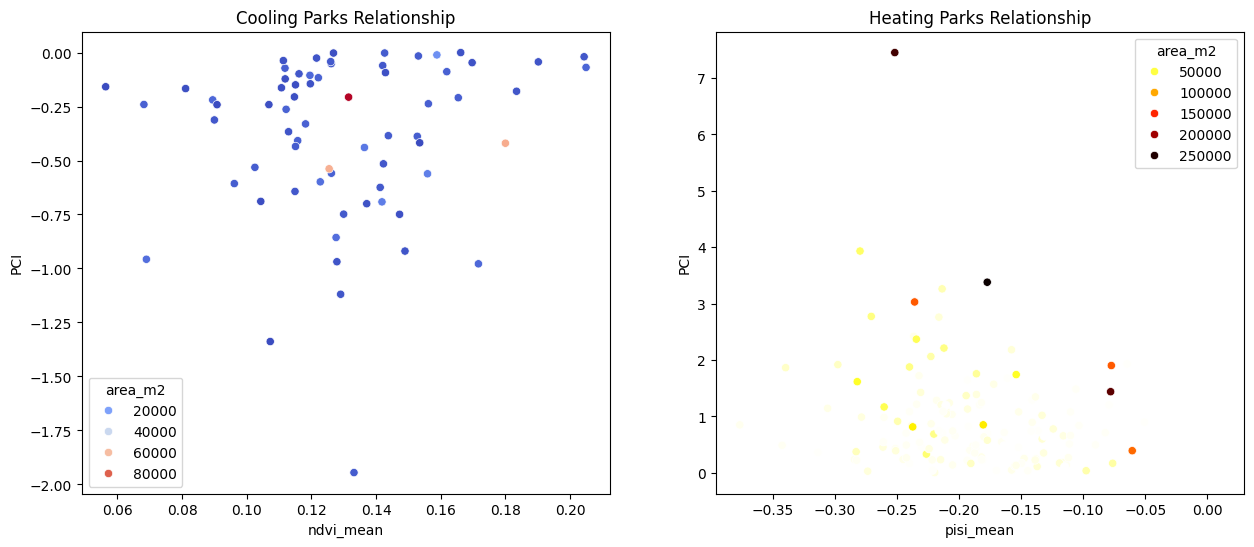

In [8]:
# Visualize fundamental differences
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=data_df_cooling, x='ndvi_mean', y='PCI', hue='area_m2', ax=ax[0], palette='coolwarm')
ax[0].set_title('Cooling Parks Relationship')
sns.scatterplot(data=data_df_heating, x='pisi_mean', y='PCI', hue='area_m2', ax=ax[1], palette='hot_r')
ax[1].set_title('Heating Parks Relationship')
plt.show()

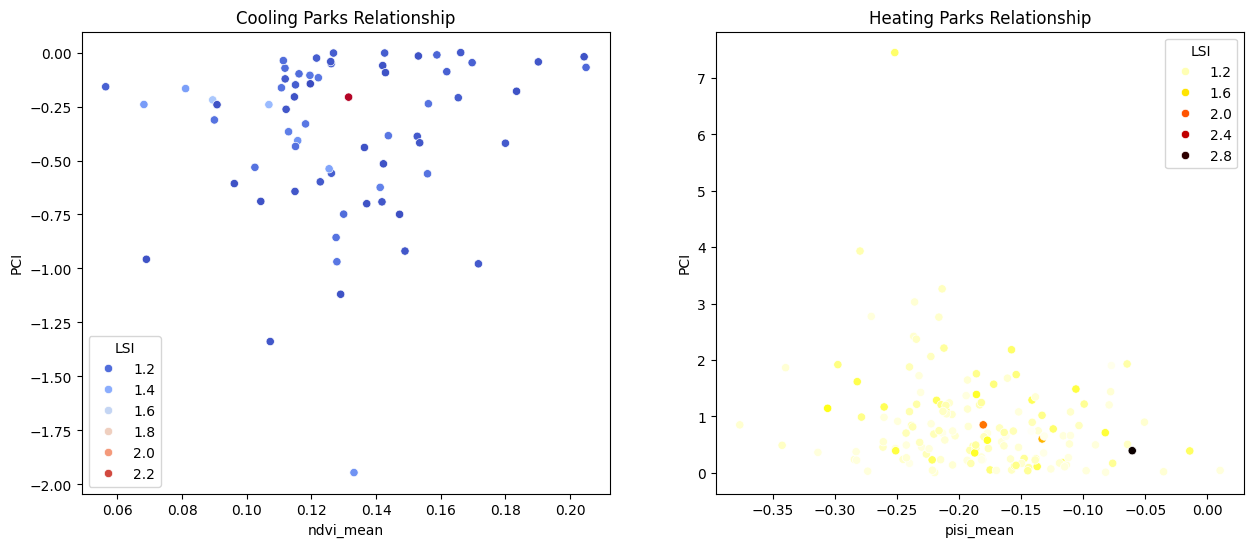

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.scatterplot(data=data_df_cooling, x='ndvi_mean', y='PCI', hue='LSI', ax=ax[0], palette='coolwarm')
ax[0].set_title('Cooling Parks Relationship')
sns.scatterplot(data=data_df_heating, x='pisi_mean', y='PCI', hue='LSI', ax=ax[1], palette='hot_r')
ax[1].set_title('Heating Parks Relationship')
plt.show()

# 2. Initial Exploration

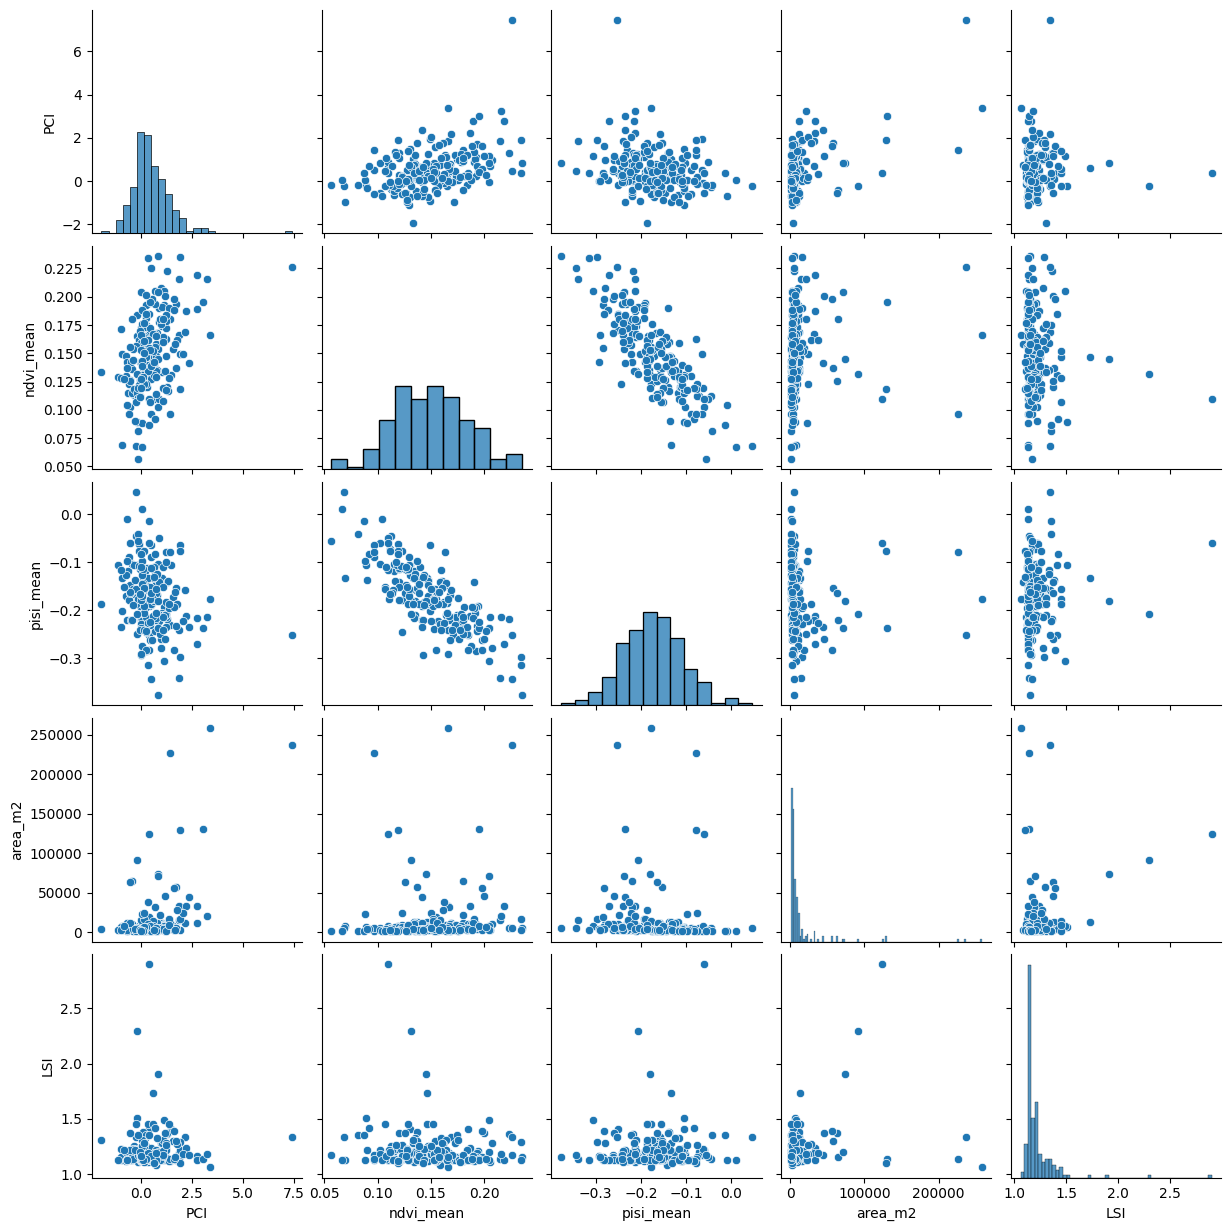

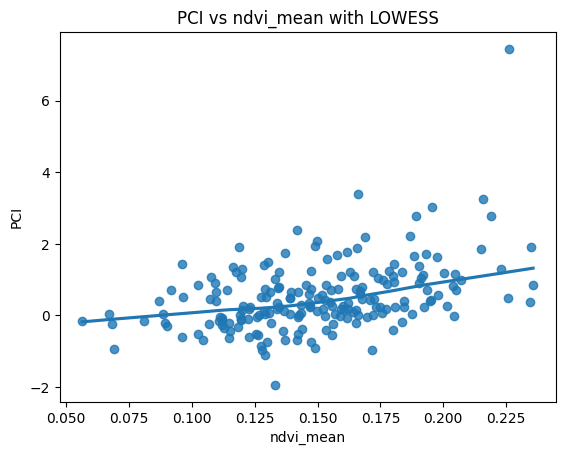

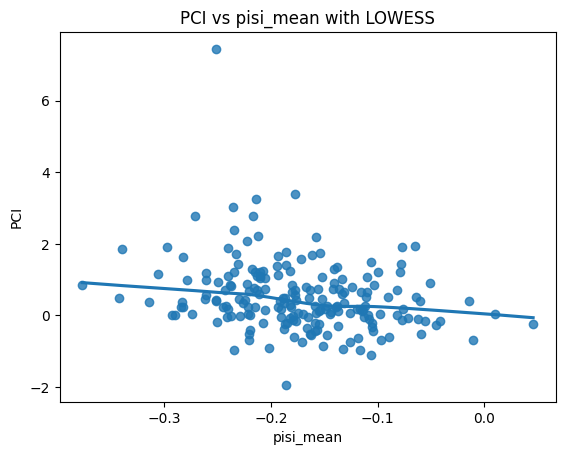

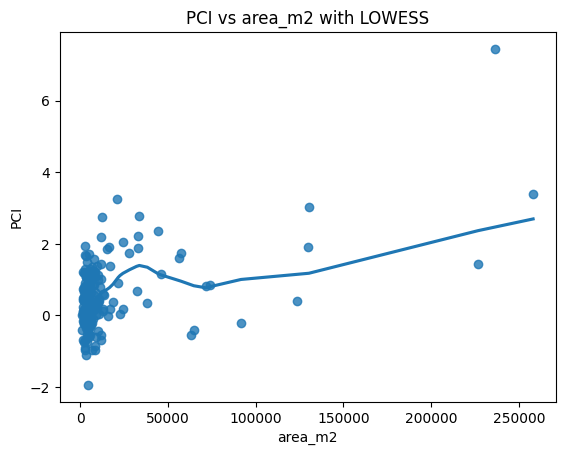

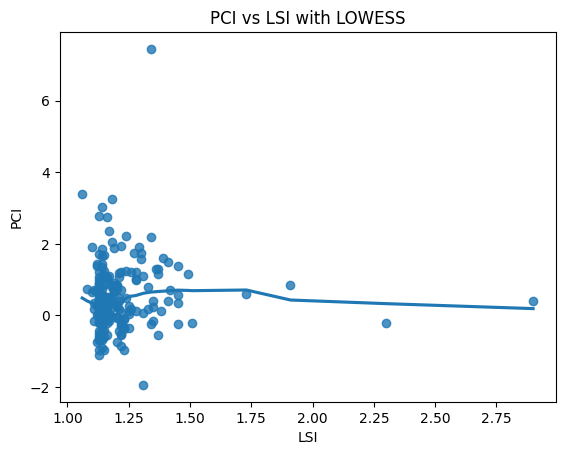

In [10]:
# Pairplots to see relationships
sns.pairplot(filtered_parks_gdf[['PCI','ndvi_mean','pisi_mean','area_m2','LSI']])
plt.show()

# Individual scatterplots with LOWESS smoothing
for var in ['ndvi_mean','pisi_mean','area_m2','LSI']:
    sns.regplot(x=filtered_parks_gdf[var], y=filtered_parks_gdf['PCI'], lowess=True)
    plt.title(f'PCI vs {var} with LOWESS')
    plt.show()

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# For PCI as example
X = filtered_parks_gdf[['ndvi_mean','pisi_mean','area_m2','LSI']]
y = filtered_parks_gdf['PCI']

# Quadratic terms
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

model = LinearRegression().fit(X_poly, y)
print(f"R-squared: {model.score(X_poly, y):.3f}")

R-squared: 0.522


In [15]:
import statsmodels.api as sm
X_poly_const = sm.add_constant(X_poly)  # Adds intercept term
model_sm = sm.OLS(y, X_poly_const).fit()
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.485
Method:                 Least Squares   F-statistic:                     14.09
Date:                Thu, 24 Jul 2025   Prob (F-statistic):           2.18e-22
Time:                        01:57:16   Log-Likelihood:                -200.74
No. Observations:                 196   AIC:                             431.5
Df Residuals:                     181   BIC:                             480.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8836      4.264     -0.911      0.3

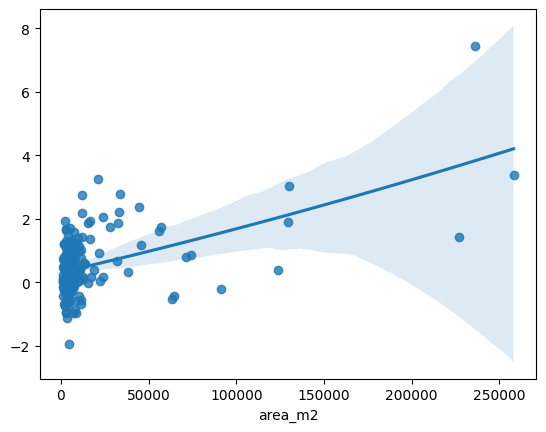

In [16]:
# For continuous variables like area_m2
sns.regplot(x=filtered_parks_gdf['area_m2'], y=y, order=2)  # Quadratic fit
plt.show()

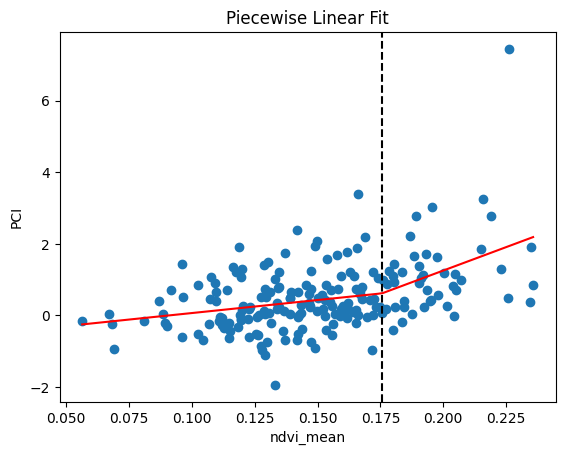

In [17]:

import pwlf

# For one predictor at a time
x = filtered_parks_gdf['ndvi_mean'].values.reshape(-1,1)
y = filtered_parks_gdf['PCI'].values

# Initialize and fit - NEW SYNTAX
my_pwlf = pwlf.PiecewiseLinFit(x.flatten(), y)  # Note .flatten()
my_pwlf.fit(2)  # Fit with 2 segments (1 breakpoint)

# Get breakpoint
breakpoint = my_pwlf.fit_breaks[1]

# Predict and plot
x_hat = np.linspace(x.min(), x.max(), 100)
y_hat = my_pwlf.predict(x_hat)

plt.scatter(x, y)
plt.plot(x_hat, y_hat, '-r')
plt.axvline(breakpoint, color='k', linestyle='--')
plt.xlabel('ndvi_mean')
plt.ylabel('PCI')
plt.title('Piecewise Linear Fit')
plt.show()

## trry 2

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
import numpy as np

# Your original data
X = filtered_parks_gdf[['ndvi_mean','pisi_mean','area_m2','LSI']]
y = filtered_parks_gdf['PCI']

# 1. STANDARDIZE FIRST
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Create polynomial features (now on standardized data)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Get feature names for interpretation
feature_names = poly.get_feature_names_out(input_features=X.columns)

2. Use Regularized Regression (Ridge)


In [19]:
# 3. Fit Ridge regression with cross-validated alpha selection
ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5).fit(X_poly, y)

# Print results
print(f"Best alpha: {ridge.alpha_}")
print(f"R-squared: {ridge.score(X_poly, y):.3f}")

# Show coefficients with names
for name, coef in zip(feature_names, ridge.coef_):
    print(f"{name}: {coef:.4f}")

Best alpha: 100.0
R-squared: 0.461
ndvi_mean: 0.2169
pisi_mean: -0.0420
area_m2: 0.1062
LSI: 0.0582
ndvi_mean^2: 0.0568
ndvi_mean pisi_mean: 0.0080
ndvi_mean area_m2: 0.1030
ndvi_mean LSI: 0.0106
pisi_mean^2: -0.0160
pisi_mean area_m2: -0.0532
pisi_mean LSI: 0.0331
area_m2^2: 0.0613
area_m2 LSI: 0.0263
LSI^2: -0.0226


In [20]:
# Option 2: LASSO for automatic feature selection
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, max_iter=10000).fit(X_poly, y)
print("\nLasso results:")
print(f"R-squared: {lasso.score(X_poly, y):.3f}")
print(f"Number of features kept: {sum(lasso.coef_ != 0)}")

# Show selected features
for name, coef in zip(feature_names, lasso.coef_):
    if abs(coef) > 0.001:  # Only show meaningful coefficients
        print(f"{name}: {coef:.4f}")


Lasso results:
R-squared: 0.481
Number of features kept: 7
ndvi_mean: 0.3196
area_m2: 0.2292
LSI: 0.0033
ndvi_mean^2: 0.0313
ndvi_mean area_m2: 0.1600
area_m2^2: 0.0342
LSI^2: -0.0049


In [21]:
# Get the most important features from Lasso
important_features = [name for name, coef in zip(feature_names, lasso.coef_) if abs(coef) > 0.001]

# Refit model with only important features
X_reduced = X_poly[:,[i for i,name in enumerate(feature_names) if name in important_features]]

final_model = LinearRegression().fit(X_reduced, y)
print(f"\nFinal Model R-squared: {final_model.score(X_reduced, y):.3f}")

# Show final coefficients
for name, coef in zip(important_features, final_model.coef_):
    print(f"{name}: {coef:.4f}")


Final Model R-squared: 0.494
ndvi_mean: 0.3431
area_m2: 0.4203
LSI: 0.1231
ndvi_mean^2: 0.0456
ndvi_mean area_m2: 0.1671
area_m2^2: 0.0035
LSI^2: -0.0247


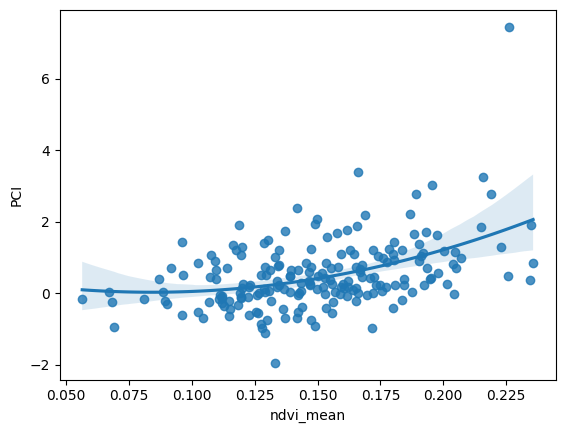

In [22]:
# For important quadratic terms
if 'ndvi_mean^2' in important_features:
    sns.regplot(x=X['ndvi_mean'], y=y, order=2)
    plt.show()

## cubic

In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare data
X = filtered_parks_gdf[['ndvi_mean','pisi_mean','area_m2','LSI']]
y = filtered_parks_gdf['PCI']

# 2. Create preprocessing pipeline with standardization
scaler = StandardScaler()
poly = PolynomialFeatures(degree=3, include_bias=False)  # Changed to degree=3 for cubic

# 3. Create modeling pipeline with Ridge regularization
model = make_pipeline(
    scaler,
    poly,
    RidgeCV(alphas=np.logspace(-3, 3, 20), cv=5)
)

# 4. Fit the model
model.fit(X, y)

# 5. Get feature names (now including cubic terms)
feature_names = poly.get_feature_names_out(input_features=X.columns)

# 6. Print results
print(f"Best alpha: {model.named_steps['ridgecv'].alpha_}")
print(f"R-squared: {model.score(X, y):.3f}")

# 7. Get and display coefficients
coefs = model.named_steps['ridgecv'].coef_
significant_features = [(name, coef) for name, coef in zip(feature_names, coefs) if abs(coef) > 0.01]

print("\nMost significant cubic terms:")
for name, coef in sorted(significant_features, key=lambda x: abs(x[1]), reverse=True):
    print(f"{name}: {coef:.4f}")

Best alpha: 26.366508987303554
R-squared: 0.530

Most significant cubic terms:
ndvi_mean: 0.2083
area_m2: 0.1476
pisi_mean^2 area_m2: 0.1238
ndvi_mean^2 pisi_mean: 0.1185
LSI: 0.1167
ndvi_mean^3: 0.0976
ndvi_mean^2: 0.0922
pisi_mean area_m2: -0.0840
area_m2 LSI: -0.0746
ndvi_mean^2 LSI: -0.0622
ndvi_mean area_m2^2: 0.0535
ndvi_mean pisi_mean: 0.0511
ndvi_mean pisi_mean area_m2: -0.0395
pisi_mean area_m2^2: 0.0386
ndvi_mean LSI: -0.0361
ndvi_mean^2 area_m2: 0.0342
pisi_mean^2 LSI: 0.0341
area_m2 LSI^2: 0.0309
pisi_mean^2: 0.0272
LSI^2: 0.0265
area_m2^2 LSI: -0.0214
ndvi_mean pisi_mean^2: 0.0208
area_m2^2: -0.0205
pisi_mean LSI: -0.0172
ndvi_mean LSI^2: 0.0148
pisi_mean area_m2 LSI: 0.0143
pisi_mean LSI^2: 0.0122
LSI^3: -0.0120
ndvi_mean area_m2 LSI: 0.0120
ndvi_mean pisi_mean LSI: -0.0111
ndvi_mean area_m2: 0.0109
